In [6]:
import open3d as o3d
import numpy as np
import random
from pathlib import Path
from tqdm import tqdm
import shutil
import json

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Параметры задачи
CLASSES = ["sphere", "cube", "cylinder", "cone", "torus"]
SPLITS = {"train": 80, "test": 20} 
POINTS_PER_OBJ = 2000 

# Параметры шума 
SIGMA_REL = 0.01
P_OUT = 0.05
BBOX_EXPAND = 1.2

ROOT_DIR = Path("data")

def get_mesh(cls_name):
    """Генерация базовых мешей со случайными параметрами"""
    if cls_name == "sphere":
        return o3d.geometry.TriangleMesh.create_sphere(radius=random.uniform(0.5, 1.0))
    elif cls_name == "cube":
        return o3d.geometry.TriangleMesh.create_box(width=1.0, height=1.0, depth=1.0) # Масштаб поправим позже
    elif cls_name == "cylinder":
        return o3d.geometry.TriangleMesh.create_cylinder(radius=random.uniform(0.3, 0.6), height=random.uniform(1.0, 1.5))
    elif cls_name == "cone":
        return o3d.geometry.TriangleMesh.create_cone(radius=random.uniform(0.4, 0.7), height=random.uniform(1.0, 1.5))
    elif cls_name == "torus":
        return o3d.geometry.TriangleMesh.create_torus(torus_radius=random.uniform(0.8, 1.0), tube_radius=random.uniform(0.2, 0.4))
    else:
        raise ValueError(f"Unknown class: {cls_name}")

def apply_noise_and_outliers(pcd):
    pts = np.asarray(pcd.points)
    
    # Расчет характерного размера d
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    extent = maxs - mins
    d = float(np.max(extent))
    center = (mins + maxs) / 2
    
    # Гауссовский шум
    sigma = SIGMA_REL * d
    noise = rng.normal(0.0, sigma, size=pts.shape)
    pts_noisy = pts + noise
    
    # Выбросы
    n_out = int(round(P_OUT * len(pts)))
    half_extent = (extent * BBOX_EXPAND) / 2
    # Генерация вокруг центра
    outliers = rng.uniform(low=center - half_extent, 
                           high=center + half_extent, 
                           size=(n_out, 3))
    
    pts_final = np.vstack([pts_noisy, outliers])
    
    # Обновление облака
    pcd_final = o3d.geometry.PointCloud()
    pcd_final.points = o3d.utility.Vector3dVector(pts_final)
    return pcd_final

def main():
    if ROOT_DIR.exists():
        shutil.rmtree(ROOT_DIR)
    ROOT_DIR.mkdir()

    print(f"Генерация датасета: {CLASSES}")
    print(f"Параметры шума: Sigma={SIGMA_REL}, Outliers={P_OUT*100}%")

    for split_name, count in SPLITS.items():
        split_dir = ROOT_DIR / split_name
        split_dir.mkdir()
        
        for cls in CLASSES:
            cls_dir = split_dir / cls
            cls_dir.mkdir()
            
            for i in tqdm(range(count), desc=f"{split_name}/{cls}"):
                # Создание
                mesh = get_mesh(cls)
                # Случайное вращение 
                R = mesh.get_rotation_matrix_from_xyz(np.random.uniform(0, 2*np.pi, 3))
                mesh.rotate(R, center=(0,0,0))
                
                # Сэмплинг точек
                pcd = mesh.sample_points_poisson_disk(POINTS_PER_OBJ)
                
                # Зашумление
                pcd_noisy = apply_noise_and_outliers(pcd)
                
                # Сохранение
                filename = f"{cls}_{i:04d}.ply"
                o3d.io.write_point_cloud(str(cls_dir / filename), pcd_noisy)
                
    print("Генерация завершена")

if __name__ == "__main__":
    main()

Генерация датасета: ['sphere', 'cube', 'cylinder', 'cone', 'torus']
Параметры шума: Sigma=0.01, Outliers=5.0%


test/torus: 100%|███████████████████████████████| 20/20 [00:03<00:00,  5.89it/s]

Генерация завершена


In [7]:
import open3d as o3d
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Параметры признаков
VOXEL_SIZE = 0.05       
RADIUS_NORMAL = 2.0 * VOXEL_SIZE
RADIUS_FEATURE = 5.0 * VOXEL_SIZE
MAX_NN = 100

CLASSES = ["sphere", "cube", "cylinder", "cone", "torus"]
CLS_TO_IDX = {c: i for i, c in enumerate(CLASSES)}
ROOT_DIR = Path("data")

def preprocess_point_cloud(pcd):
    # Downsample -> Normals
    pcd_down = pcd.voxel_down_sample(VOXEL_SIZE)
    
    # Оценка нормалей 
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=RADIUS_NORMAL, max_nn=30)
    )
    pcd_down.orient_normals_consistent_tangent_plane(30)
    return pcd_down

def extract_global_fpfh(pcd):
    """
    Вычисляет FPFH для каждой точки, затем агрегирует в глобальный вектор
    """
    # Вычисляем FPFH
    fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd,
        o3d.geometry.KDTreeSearchParamHybrid(radius=RADIUS_FEATURE, max_nn=MAX_NN)
    ).data # (33, N)
    
    # Average + Std Pooling
    mu = np.mean(fpfh, axis=1)
    sigma = np.std(fpfh, axis=1)
    
    feature_vector = np.concatenate([mu, sigma])
    return feature_vector

def load_dataset(split_name):
    X = []
    y = []
    
    split_dir = ROOT_DIR / split_name
    print(f"Загрузка и обработка {split_name}...")
    
    files = list(split_dir.glob("*/*.ply"))
    
    for file_path in tqdm(files):
        # Получаем класс 
        cls_name = file_path.parent.name
        if cls_name not in CLS_TO_IDX:
            continue
            
        label = CLS_TO_IDX[cls_name]
        
        # Загрузка
        pcd = o3d.io.read_point_cloud(str(file_path))
        
        # Препроцессинг
        pcd_prep = preprocess_point_cloud(pcd)
        
        # Если точек слишком мало - пропускаем
        if len(pcd_prep.points) < 10:
            continue
            
        # Извлечение признаков
        features = extract_global_fpfh(pcd_prep)
        
        X.append(features)
        y.append(label)
        
    return np.array(X), np.array(y)

# Подготовка данных
X_train, y_train = load_dataset("train")
X_test, y_test = load_dataset("test")

print(f"\nРазмерности: Train {X_train.shape}, Test {X_test.shape}")

# Обучение классификатора SVM 
print("Обучение SVM")
clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", C=10.0, gamma="scale")
)

clf.fit(X_train, y_train)

# Валидация
y_pred = clf.predict(X_test)

# Результаты
print("\n" + "="*40)
print("Результаты классификации")
print("="*40)
print(classification_report(y_test, y_pred, target_names=CLASSES, digits=4))

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1-Score: {f1:.4f}")
print("-" * 20)

if f1 >= 0.95:
    print("Оценка: Отлично")
elif f1 >= 0.85:
    print("Оценка: Хорошо")
else:
    print("Оценка: Удовлетворительно")

print("\nMatix of Confusion:")
print(confusion_matrix(y_test, y_pred))

Загрузка и обработка train...


100%|█████████████████████████████████████████| 400/400 [00:18<00:00, 21.64it/s]


Загрузка и обработка test...


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.93it/s]


Размерности: Train (400, 66), Test (100, 66)
Обучение SVM

Результаты классификации
              precision    recall  f1-score   support

      sphere     1.0000    1.0000    1.0000        20
        cube     1.0000    1.0000    1.0000        20
    cylinder     1.0000    1.0000    1.0000        20
        cone     1.0000    1.0000    1.0000        20
       torus     1.0000    1.0000    1.0000        20

    accuracy                         1.0000       100
   macro avg     1.0000    1.0000    1.0000       100
weighted avg     1.0000    1.0000    1.0000       100

Weighted F1-Score: 1.0000
--------------------
Оценка: Отлично

Matix of Confusion:
[[20  0  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 20  0  0]
 [ 0  0  0 20  0]
 [ 0  0  0  0 20]]


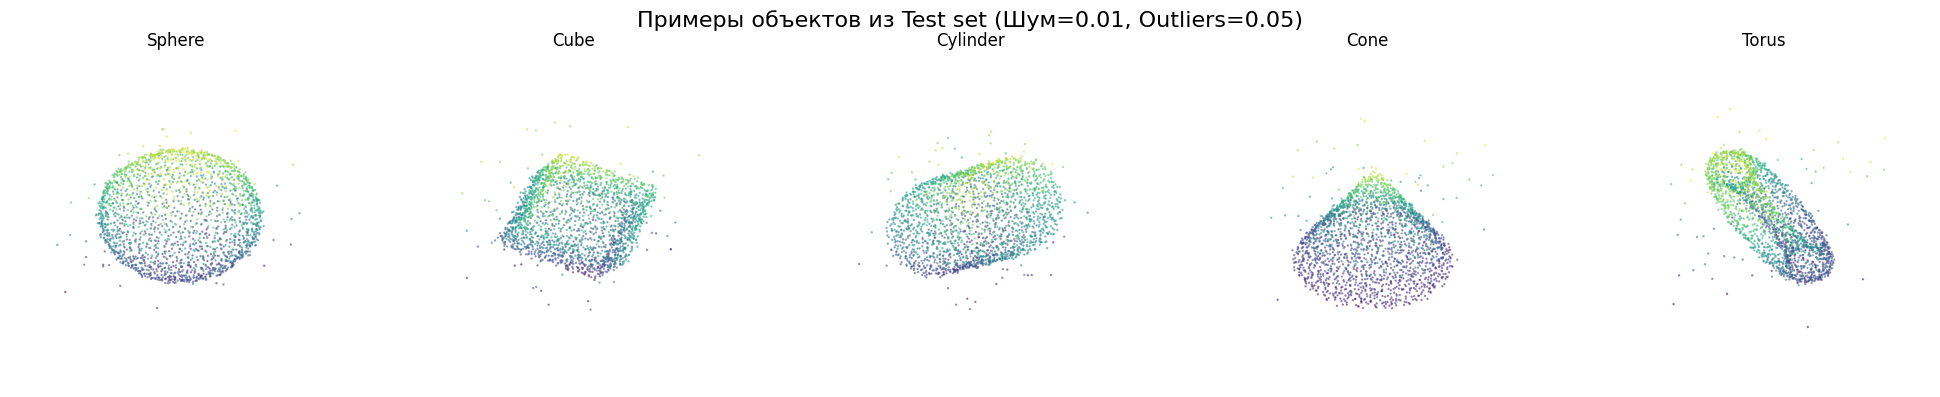

PCA проекция признаков


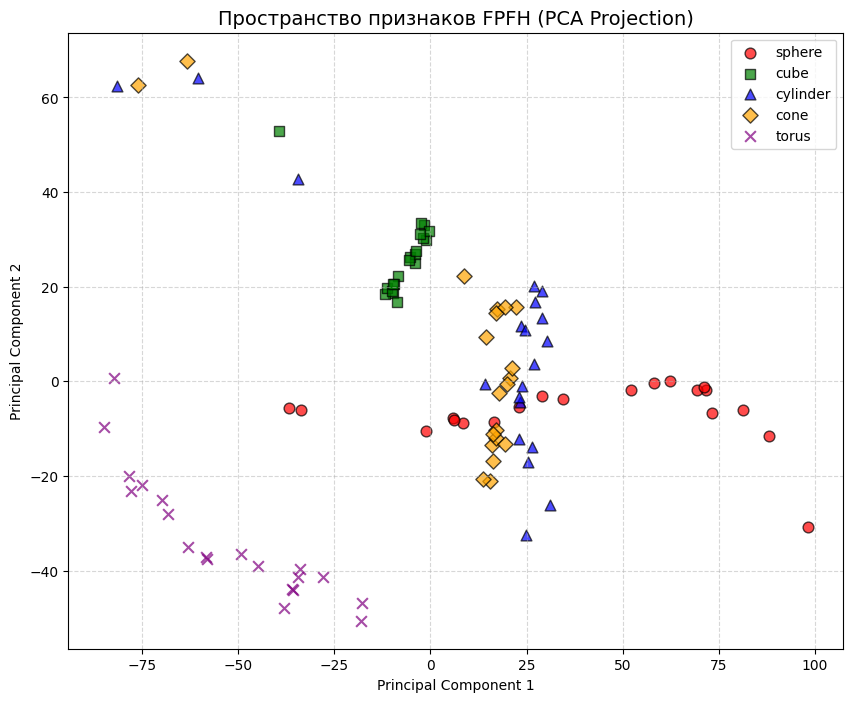

In [11]:
def plot_feature_space(X, y):
    print("PCA проекция признаков")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    plt.title("Пространство признаков FPFH (PCA Projection)", fontsize=14)
    
    colors = ['r', 'g', 'b', 'orange', 'purple']
    markers = ['o', 's', '^', 'D', 'x']
    
    for i, cls in enumerate(CLASSES):
        # Выбираем точки, относящиеся к классу i
        idx = (y == i)
        
        if markers[i] == 'x':
            plt.scatter(X_pca[idx, 0], X_pca[idx, 1], 
                        c=colors[i], label=cls, alpha=0.7, s=60, marker=markers[i])
        else:
            plt.scatter(X_pca[idx, 0], X_pca[idx, 1], 
                        c=colors[i], label=cls, alpha=0.7, edgecolors='k', s=60, marker=markers[i])
        
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

plot_class_gallery()
plot_feature_space(X_test, y_test)